# Diseño Evolutivo de Redes Neuronales Artificiales
# Evolutionary Design of Artificial Neural Networks
# DERNA/EDANN

Basado en el paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

Este programa reproduce los resultados del paper en ANN para el DJI usando datos obtenidos de Yahoo Finance. Se calcularon los indicadores técnicos según las fórmulas del paper y las indicaciones del autor.

Se usan los datos del DJI desde 20050401 hasta 20170331.
En el artículo, el autor logra una pérdida de 0.001-0.013 (media de 0.004), este logra 0.0335

Based on the paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

This programs reproduces the paper results on ANN for DJI using data from Yahoo Finance. The technical indicators were calculated based on the paper formulas and the author advise.

This program uses DJI data from 20050401 until 20170331.
In the paper the author achieves a loss of 0.001-0.013 (mean of 0.004), this one achieves 0.0335

baseline_kaur

V 1.0 20200505

V 2.0 20210520 Traducción de comentarios y correcciones de estilo. Se eliminaron las trazas de depuración.

V 2.1 20210529 Prueba con los primeros 1000 datos

##### Importar librerías y funciones
##### Import libraries and functions

In [5]:
import numpy as np
import sklearn.preprocessing as skp
import tensorflow as tf
import matplotlib.pyplot as plt

##### Hiperparámetros
##### Hyperparameters

In [6]:
p = {
    "local_file": "baseline_kaur.csv",
    "url": "https://raw.githubusercontent.com/" +
           "jmacostap/webstore/master/baseline_kaur.csv",
    "cache_dir": "/content",
    "use_scaler": True,
    "scaler": skp.MinMaxScaler(feature_range=(-1,1)),
    "test_fraction": 0.20,  # 20% para prueba/20% of samples for test data
    "neurons": 9,
    "activation": "sigmoid",  # para la capa oculta/for the hidden layer
    "output_activation": "linear",  # capa de salida/for the output layer
    "optimizer": tf.keras.optimizers.SGD(
        learning_rate=0.3,
        momentum=0.2,
        nesterov=False),
    "loss": "mse",  # podría ser mae o mse/could be mae or mse
    "epochs": 500,  # épocas de entrenamiento/training epochs
    "batch_size": 100,
    "shuffle": False,  # los datos de entrenamiento/the training data
    "verbose": 0,  # verbosidad del entrenamiento/verbose training
    }

##### Leer los datos del repositorio
##### Read data from repository

In [7]:
path_to_downloaded_file = tf.keras.utils.get_file(
    p["local_file"],
    p["url"],
    cache_dir=p["cache_dir"],
    )
data = np.loadtxt(path_to_downloaded_file, skiprows=1, delimiter=",")[0:1000]
print(f"{data.shape} samples read")

# extraer objetivos/extract targets
targets = np.reshape(data[:, -1], (-1, 1))
print(f"Targets to be used: {targets.shape}")

# extraer datos/extract features
data = data[:, :-1]
print(f"Samples to be used: {data.shape}")

# normalizar datos/normalize data
if p["use_scaler"]:
    data_scaler = p["scaler"]
    data = data_scaler.fit_transform(data)
    targets_scaler = p["scaler"]
    targets = targets_scaler.fit_transform(targets)

# reservar datos de prueba/reserve test data
test_fraction = np.int(len(data)*p["test_fraction"])
print(f"Test fraction: {test_fraction}")
train_targets = targets[:-test_fraction]
print(f"Train targets: {train_targets.shape}")
train_data = data[:-test_fraction]
print(f"Train samples: {train_data.shape}")
test_targets = targets[-test_fraction:]
print(f"Test targets: {test_targets.shape}")
test_data = data[-test_fraction:]
print(f"Test samples: {test_data.shape}")

688128/687922 [==============================] - 0s 0us/step
(1000, 13) samples read
Targets to be used: (1000, 1)
Samples to be used: (1000, 12)
Test fraction: 200
Train targets: (800, 1)
Train samples: (800, 12)
Test targets: (200, 1)
Test samples: (200, 12)


##### Crear la RNA
##### Create the ANN

In [8]:
# asegura reproducibilidad y consistencia
# ensure reproducibility and consistency
tf.random.set_seed(31416)  # keras

# definir el modelo/define the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            p["neurons"],
            activation=p["activation"],
            input_shape=(data.shape[1],),
        ),
        tf.keras.layers.Dense(
            1,
            activation=p["output_activation"],
        ),
    ]
)

# crear el modelo/create the model
model.compile(
    optimizer=p["optimizer"],
    loss=p["loss"],
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 117       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None


##### Entrenar la RNA
##### Train the ANN

In [9]:
# Entrenar el modelo/train the model
history = model.fit(
    train_data,
    train_targets,
    epochs=p["epochs"],
    batch_size=p["batch_size"],
    shuffle=p["shuffle"],
    verbose=p["verbose"],
    validation_split=p["test_fraction"],
    #use_multiprocessing=True,
    )
loss = model.evaluate(train_data, train_targets)
print(f"Train error: {loss}")

25/25 [==============================] - 0s 1ms/step - loss: 0.0011
Train error: 0.0010590413585305214


##### Visualizar el entrenamiento
##### Visualize training

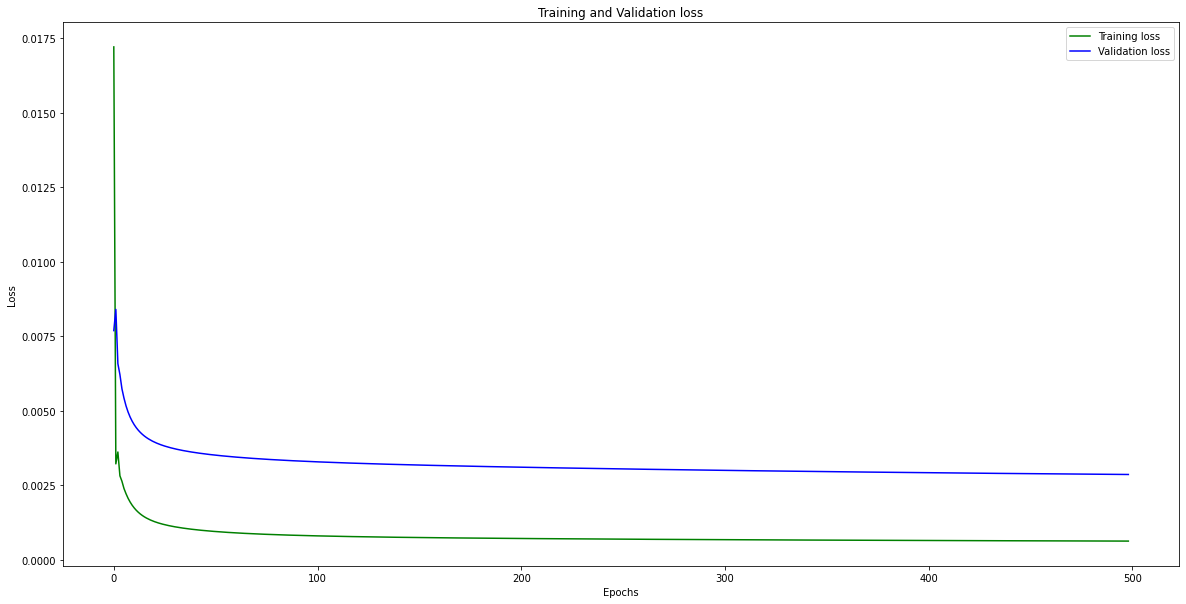

In [10]:
fro = 1  # evitar problemas de escala/avoid autoscale issues
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'][fro:], 'g', label='Training loss')
plt.plot(history.history['val_loss'][fro:], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Probar la RNA
##### Test the ANN

In [11]:
loss_error = model.evaluate(test_data, test_targets)
print(f"Test error: {loss_error}")

7/7 [==============================] - 0s 2ms/step - loss: 0.0335
Test error: 0.033524975180625916


##### Despliegue gráfico del rendimiento de la RNA entrenada
##### Graphically display the performance of the trained ANN

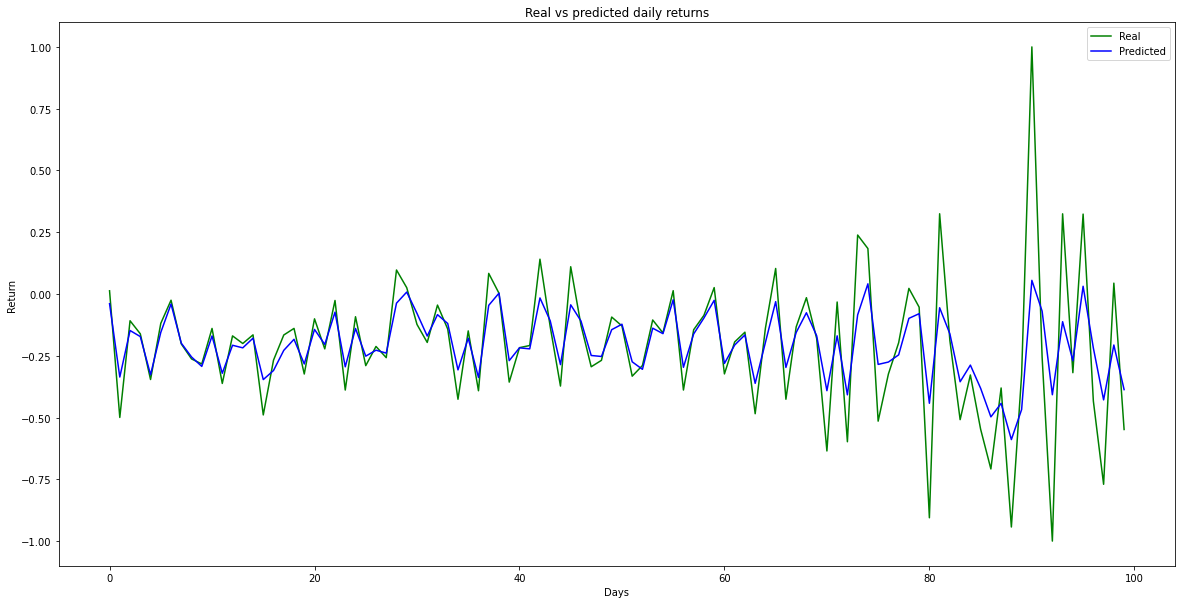

In [12]:
y_pred = model.predict(test_data[0:100])
plt.figure(figsize=(20,10))
plt.plot(test_targets[0:100], 'g', label='Real')
plt.plot(y_pred, 'b', label='Predicted')
plt.title('Real vs predicted daily returns')
plt.xlabel('Days')
plt.ylabel('Return')
plt.legend()
plt.show()